In [1]:
import re
import urllib3
import certifi

#construct regular expressions
title_regex=re.compile(r"class=\"title\"><h3>(.+)</h3>")
date_regex=re.compile(r"class=\"clamp-details\">\s+<span>(.+)</span>")
description_regex=re.compile(r"<div class=\"summary\">\s*([\S\s]+?)\s*</div>")
score_regex = re.compile(r"<span class=\"title\">Metascore:</span>\s+<a class=\"metascore_anchor\" href=\"/movie/.*?/critic-reviews\">\s+<div class=\"metascore_w large movie .+\">(.*?)</div>")
image_regex = re.compile(r"<a href=\"/movie/.*\"><img src=\"(.*)\" alt=\"")
                           
#construct HTTP pool for connections
http = urllib3.PoolManager(ca_certs=certifi.where())

In [2]:
#connect to Mongodb
import json
import pymongo
import certifi
with open ('C:\\Users\\Luckybrindle\\Documents\\School\\FALL 2022\\DA 320\\secrets.json') as f: 
    data = json.load(f)
    
#connect to mongodb connection string
mongodb_connection_string = data['mongodb_connection_string']

#connect to database using known good certificates
client = pymongo.MongoClient(mongodb_connection_string, tlsCAFile=certifi.where())
db = client.DA320
metacritic_data = db['Metacritic']

In [16]:
#webscraping function 
import pandas as pd
def metacritic_scraper(year:int, page: int) -> pd.DataFrame:
    #fetch webpage
    url = f"https://www.metacritic.com/browse/movies/score/metascore/year/filtered?year_selected={year}&sort=desc&view=detailed&page={page}"
    #construct Python request pool
    response = http.request('GET',url,headers={'User-Agent':'Mozilla/5.0'})
    datastring = str(response.data, "utf-8")
    
    #execute regular expressions 
    titles = title_regex.findall(datastring)
    dates = date_regex.findall(datastring)
    descriptions = description_regex.findall(datastring)
    scores = score_regex.findall(datastring)
    images = image_regex.findall(datastring)
    #return unified collection  
    print("title: " , len(titles), "date: " , len(dates), "description: " , len(descriptions), "score: " , len(scores), "image: " , len(images))
    dataset = {"title": titles, "date": dates, "description": descriptions, "score": scores, "image":images}
    return pd.DataFrame(dataset) 

In [18]:
#create loop through years and pages
import re
import time

#CVS file
for year in range(2005,2010):
    page=0
    print(f"Collection date for {year} page {page}.....")

#run a page multiple times
    while True:
        data = metacritic_scraper(year,page)

#stop at page with no rows
        if len(data) == 0:
            break

 #create a list of movies
    movies_to_insert =[]
    for row in data.itertuples():
        movie = {
            "title": row.title,
            "release_date": row.date,
            "description": row.description,
            "metascore": row.score,
            "image_url": row.image,
         }
        movies_to_insert.append(movie)
         
      #insert resords into MongoDB
    print(f"Inserting{len(movies_to_insert)} moview for year {year} page {page}")
    metacritic_data.insert_many(movies_to_insert)
    page = page+1

Collection date for 2005 page 0.....
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 image:  100
title:  100 date:  100 description:  100 score:  100 

KeyboardInterrupt: 

In [21]:
#reteive collection from mongodb
import json
import pymongo
import certifi
import pandas

# Retrieve credentials for MongoDB server from my credentials file
with open ('C:\\Users\\Luckybrindle\\Documents\\School\\FALL 2022\\DA 320\\secrets.json') as f:
    data = json.load(f)

# Fetch the database DA320
client = pymongo.MongoClient (tlsCAFile=certifi.where())
da320_database = client['DA-320']
metactritic_data = da320_database['metacritic']
metacritic = pandas.DataFrame(metacritic_data.find())

metacritic.head()

,_id,movie_id,title,release_date,description,score,image_url
0,637073668f5bca1f40b93322,5,A Prophet,2/26/2010,"Condemned to six years in prison, Malik El Dje...",90,https://static.metacritic.com/images/products/...
1,637073668f5bca1f40b93346,41,Let Me In,10/1/2010,I am Love tells the story of the wealthy Recch...,79,https://static.metacritic.com/images/products/...
2,637073668f5bca1f40b93326,9,45365,6/18/2010,45365 takes us on an unforgettable journey int...,88,https://static.metacritic.com/images/products/...
3,637073668f5bca1f40b93337,26,Marwencol,10/8/2010,"Mademoiselle Chambon is an elegant, moving tal...",82,https://static.metacritic.com/images/products/...
4,637073668f5bca1f40b93339,28,Blue Valentine,12/29/2010,"Magic, fantasy, and Celtic mythology come toge...",81,https://static.metacritic.com/images/products/...


In [24]:
#transform data in pandas 
metacritic.release_date = pandas.to_datetime (metacritic.release_date)
metacritic['year'] = metacritic.release_date.dt.year
metacritic['month'] = metacritic.release_date.dt.month
metacritic.score = pandas.to_numeric(metacritic.score)
metacritic.head()

,_id,movie_id,title,release_date,description,score,image_url,year,month
0,637073668f5bca1f40b93322,5,A Prophet,2010-02-26,"Condemned to six years in prison, Malik El Dje...",90,https://static.metacritic.com/images/products/...,2010,2
1,637073668f5bca1f40b93346,41,Let Me In,2010-10-01,I am Love tells the story of the wealthy Recch...,79,https://static.metacritic.com/images/products/...,2010,10
2,637073668f5bca1f40b93326,9,45365,2010-06-18,45365 takes us on an unforgettable journey int...,88,https://static.metacritic.com/images/products/...,2010,6
3,637073668f5bca1f40b93337,26,Marwencol,2010-10-08,"Mademoiselle Chambon is an elegant, moving tal...",82,https://static.metacritic.com/images/products/...,2010,10
4,637073668f5bca1f40b93339,28,Blue Valentine,2010-12-29,"Magic, fantasy, and Celtic mythology come toge...",81,https://static.metacritic.com/images/products/...,2010,12


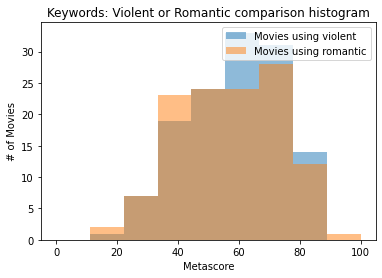

In [27]:
#comparing movies by keywords using histogram
#keywords are "Violent" and "Romance"
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter
import numpy

#get the score for movies with the keywords violent and romantic
scores_happy = metacritic[metacritic['description'].str.contains("violent")].score
scores_sad = metacritic[metacritic['description'].str.contains("romantic")].score

#construct bins
bins = numpy.linspace(0, 100, 10)
pyplot.title("Keywords: Violent or Romantic comparison histogram")
pyplot.xlabel('Metascore')
pyplot.ylabel('# of Movies')
pyplot.hist (scores_happy, bins, alpha=0.5, label='Movies using violent')
pyplot.hist (scores_sad, bins, alpha=0.5, label='Movies using romantic')

pyplot.legend (loc='upper right')
pyplot.show()

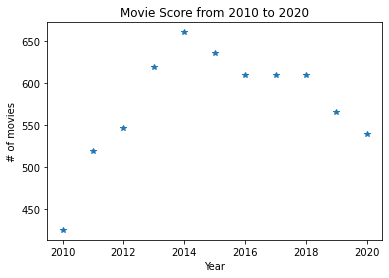

In [29]:
#scatter plot comparing movies over a period of time
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter

# Set up labels on the axes
pyplot.title('Movie Score from 2010 to 2020')
pyplot.xlabel('Year')
pyplot.ylabel('# of movies')

# Count movies measured by metacritic by year and plot the results
df = metacritic['year'].groupby(metacritic.year).agg ('count')
pyplot.plot(df,'*')
pyplot.show()